In [ ]:
! pip install kaggle &> /dev/null
! pip install torch torchvision &> /dev/null
! pip install opencv-python pycocotools matplotlib onnxruntime onnx &> /dev/null
! pip install git+https://github.com/facebookresearch/segment-anything.git &> /dev/null
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
MASK_DIR = "_data/combined/train/leaf_instances"
RGB_DIR = "_data/combined/train/images"

In [4]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [14]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
sam_model = sam_model_registry[model_type]()
sam_model.to(device)
amg = SamAutomaticMaskGenerator(sam_model)
#sam_model.train();

In [6]:
from torch.utils.data import Dataset
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide
import os

transform = ResizeLongestSide(sam_model.image_encoder.img_size)

class LeafInstanceDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.files = os.listdir(os.path.join(path, "images"))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.path, "images", self.files[idx])
        mask_path =  os.path.join(self.path, "leaf_instances", self.files[idx])
        mask_im = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.array(mask_im)

        unique_categories = np.unique(mask)
        unique_categories = unique_categories[unique_categories > 0]  # Exclude background (assumed to be 0)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        input_image = transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=device)
        transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

        input_image = sam_model.preprocess(transformed_image)
        original_image_size = image.shape[:2]
        input_size = tuple(transformed_image.shape[-2:])
        
        data = [{}] * len(unique_categories)
        
        for category_index, category_id in enumerate(unique_categories):
            y, x = np.nonzero(mask)
            x_min = np.min(x)
            y_min = np.min(y)
            x_max = np.max(x)
            y_max = np.max(y)
            data[category_index]["bbox"] = np.array([x_min, y_min, x_max, y_max])
            data[category_index]["bbox_transformed"] = transform.apply_boxes(np.array([x_min, y_min, x_max, y_max]), original_image_size)
            data[category_index]["mask"] = (mask == category_id).squeeze()
            data[category_index]["image"] = input_image.squeeze()
            data[category_index]["input_size"] = input_size
            data[category_index]['original_image_size'] = original_image_size
            
        return data

In [6]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [7]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCELoss()

In [ ]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

from torch.utils.data import DataLoader

num_epochs = 100
losses = []
data_loader = DataLoader(LeafInstanceDataset("_data/combined/train"))

for epoch in range(num_epochs):
    epoch_losses = []
    p_bar = tqdm(data_loader)
    for data in p_bar:
        for i in range(len(data)):
            input_image = data[i]['image'].to(device)
            input_size = data[i]['input_size']
            original_image_size = data[i]['original_image_size']

            # No grad here as we don't want to optimise the encoders
            with torch.no_grad():
              image_embedding = sam_model.image_encoder(input_image)

              box = data[i]["bbox_transformed"]
              box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
              box_torch = box_torch[None, :]

              sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                  points=None,
                  boxes=box_torch,
                  masks=None,
              )
            low_res_masks, iou_predictions = sam_model.mask_decoder(
              image_embeddings=image_embedding,
              image_pe=sam_model.prompt_encoder.get_dense_pe(),
              sparse_prompt_embeddings=sparse_embeddings,
              dense_prompt_embeddings=dense_embeddings,
              multimask_output=False,
            )

            upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
            binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

            data[i]["mask"] = data[i]["mask"].squeeze()
            gt_mask_resized = torch.from_numpy(np.resize(data[i]["mask"], (1, 1, data[i]["mask"].shape[0], data[i]["mask"].shape[1]))).to(device)
            gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

            loss = loss_fn(binary_mask, gt_binary_mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            p_bar.set_description(f"Loss: {loss.item()}")
    torch.save(f"out/checkpoints/sam_{epoch}.pt")
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

Loss: 0.6659927368164062:   2%|▏         | 187/10010 [01:34<1:17:48,  2.10it/s]

In [8]:
def dice_loss(pred, target, smooth=1.):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [20]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

from torch.utils.data import DataLoader

num_epochs = 100
losses = []
data_loader = DataLoader(LeafInstanceDataset("_data/combined/train"))

for epoch in range(num_epochs):
    epoch_losses = []
    p_bar = tqdm(data_loader)
    for data in p_bar:
          input_image = data[0]['image'].to(device)
          input_size = data[0]['input_size']
          original_image_size = data[0]['original_image_size']

          # No grad here as we don't want to optimise the encoders
          with torch.no_grad():
            predictions = amg.generate(data[0]["image"].squeeze())

          target_mask = torch.zeros(data[0]["mask"].shape)
#          target_mask = torch.unsqueeze(target_mask, 0)
            
          for i, d in enumerate(data):
            target_mask[d["mask"] > 0] = i
          
          pred_mask = torch.zeros(input_size)

          for i, p in enumerate(predictions):
            target_mask[p["segmentation"] > 0] = i
          print(pred_mask.shape, target_mask.shape)
          loss = dice_loss(pred_mask, target_mask)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_losses.append(loss.item())
          p_bar.set_description(f"Loss: {loss.item()}")
    losses.append(epoch_losses)
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/10010 [00:00<?, ?it/s]

torch.Size([1024, 1024]) torch.Size([1, 512, 512])


RuntimeError: The size of tensor a (1048576) must match the size of tensor b (262144) at non-singleton dimension 0

In [ ]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

In [5]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)

In [7]:
import random
import os
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image_file = os.path.join("_data/combined/test", image_file)
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [8]:
predictor_tuned.set_image(image)

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=None,
    multimask_output=True,
)

NameError: name 'predictor_tuned' is not defined

In [9]:
def show_masks(masks, ax):
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [10]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

NameError: name 'masks_tuned' is not defined

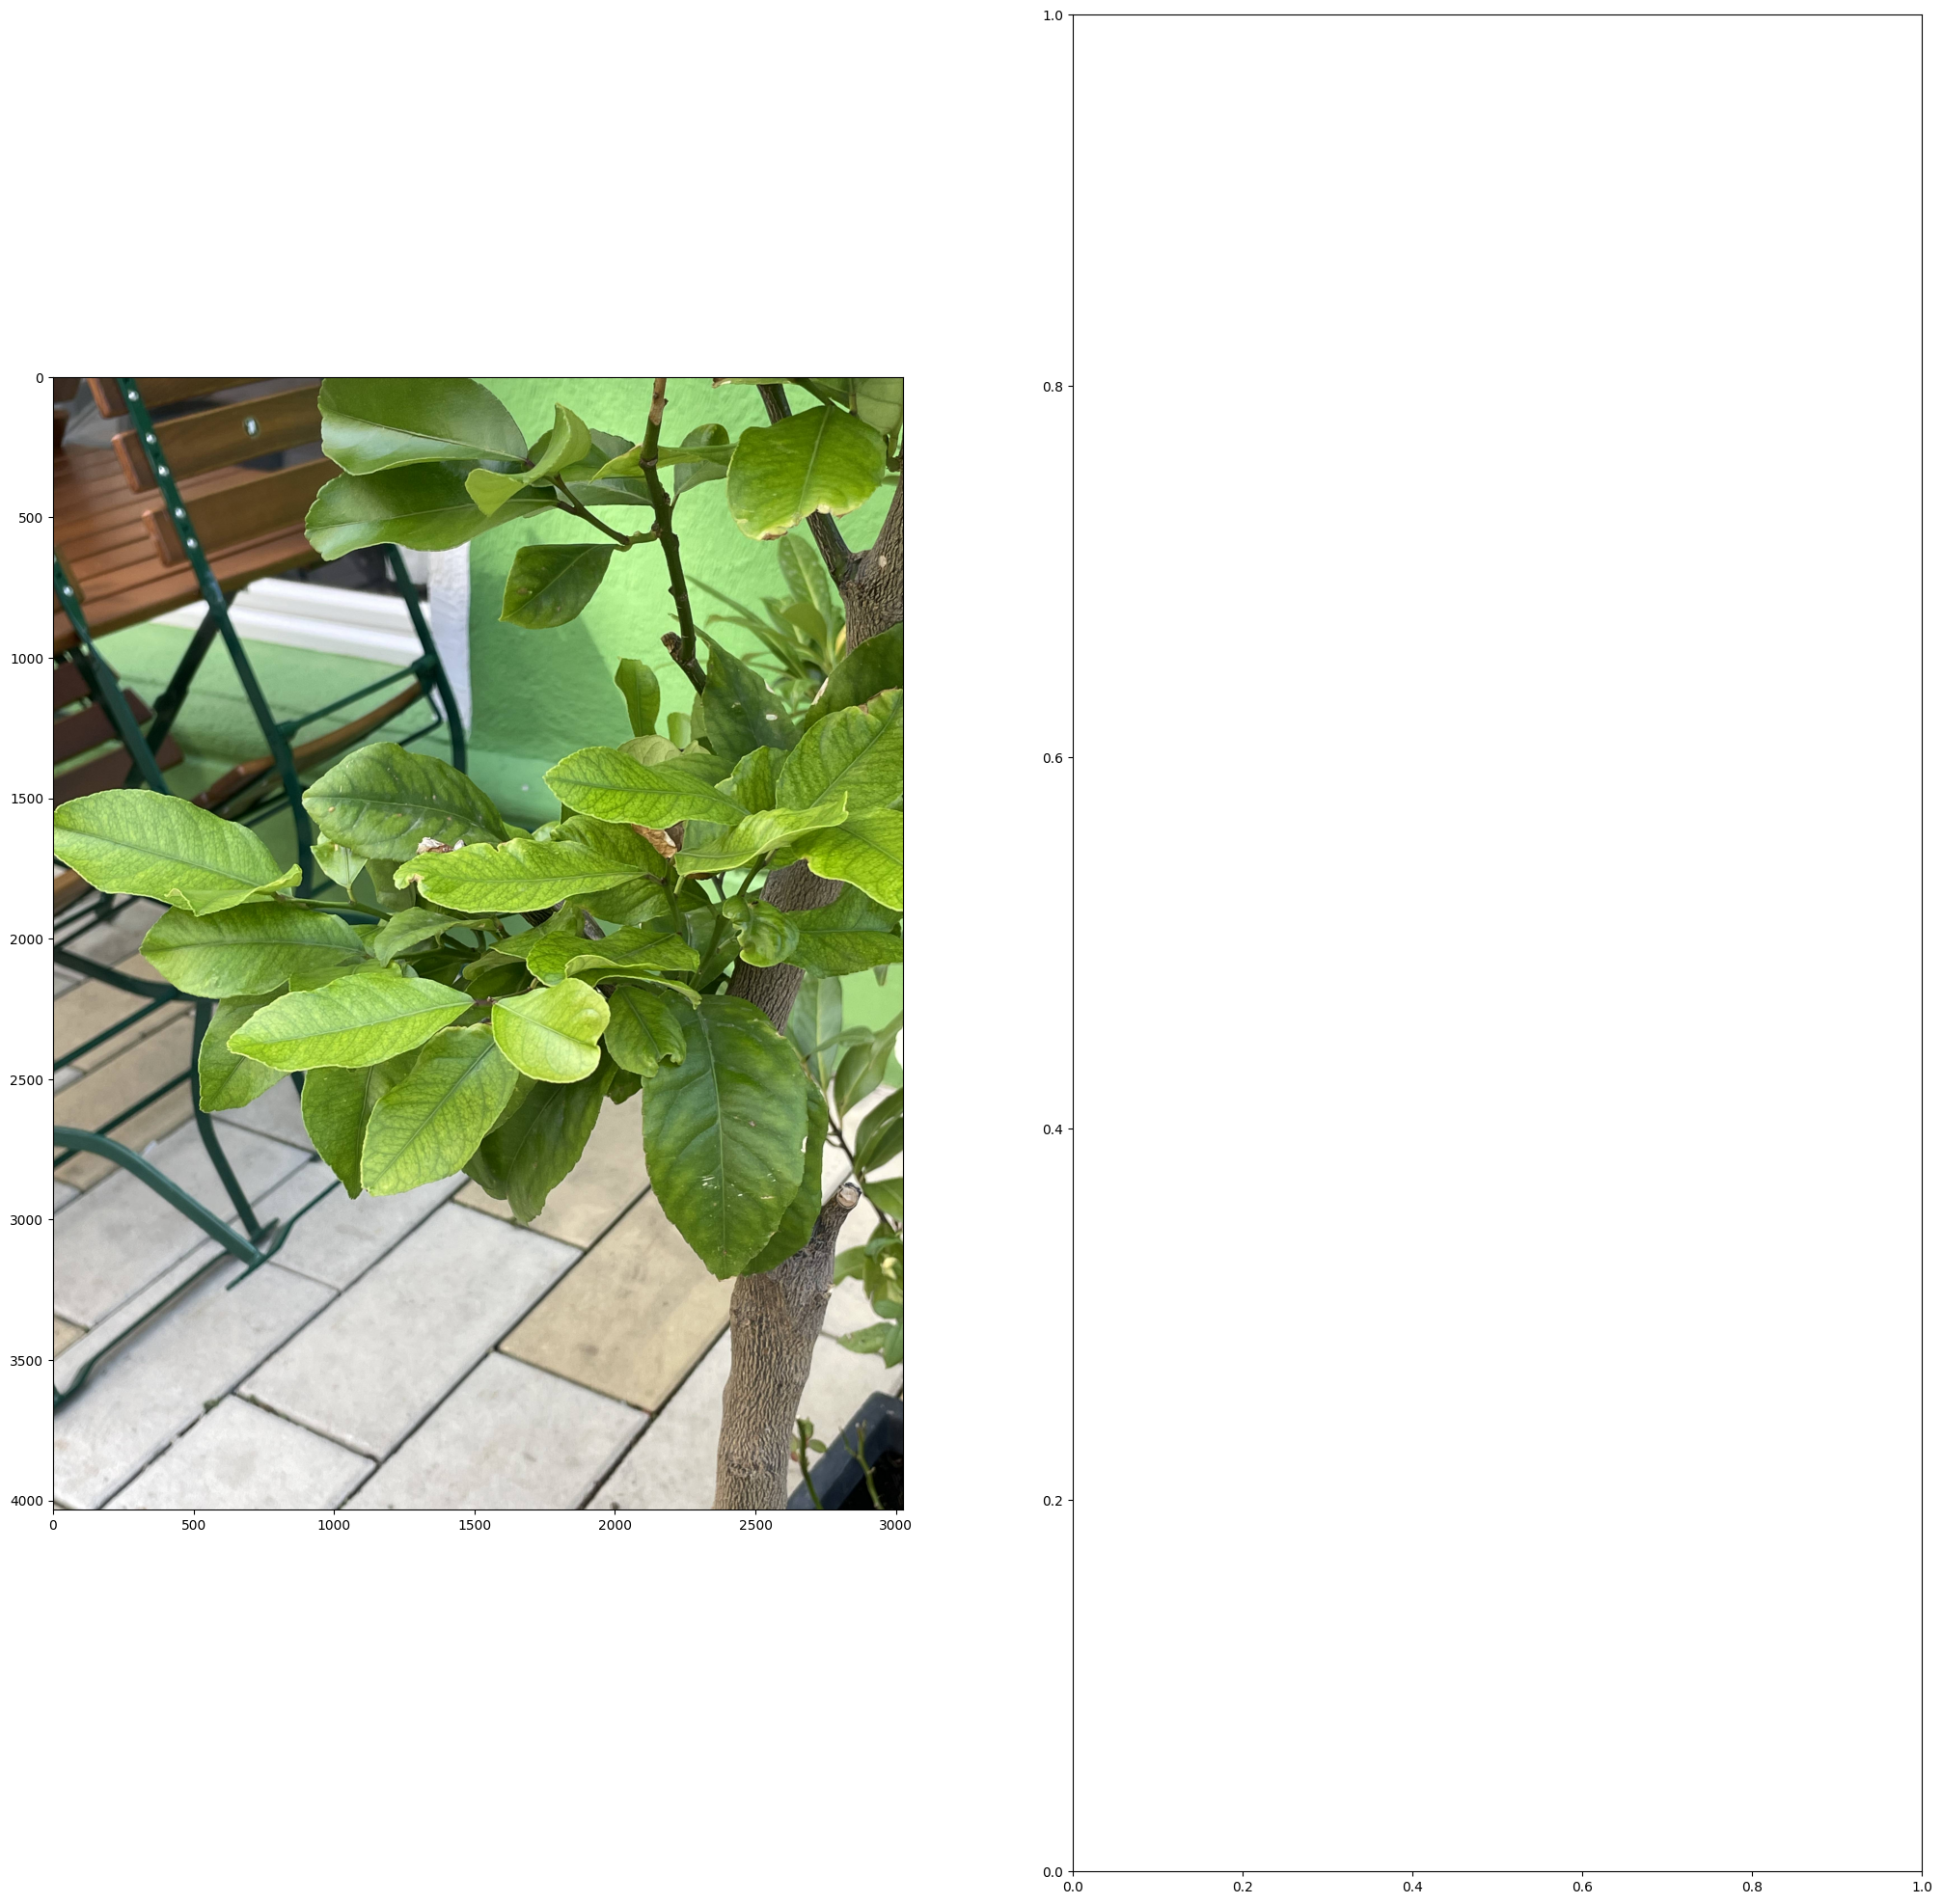

In [11]:
%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


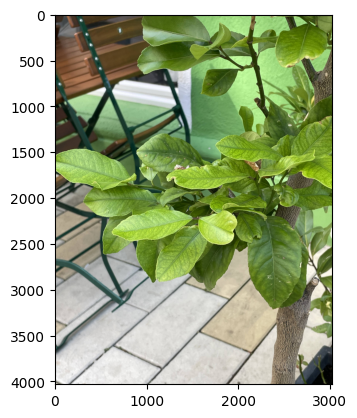

In [12]:
plt.imshow(image)

In [15]:
amg.generate(image)

[]